# Predicting house prices using k-nearest neighbors regression

In this notebook, you will implement k-nearest neighbors regression. You will:

* Find the k-nearest neighbors of a given query input
* Predict the output for the query input using the k-nearest neighbors
* Choose the best value of k using a validation set

In [1]:
import graphlab
sales = graphlab.SFrame('kc_house_data_small.gl/')
import numpy as np

This non-commercial license of GraphLab Create for academic use is assigned to mikael.baymani@gmail.com and will expire on May 13, 2020.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1565775436.log


In [2]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_sframe = graphlab.SFrame()
    for feature in features:
        features_sframe[feature] = data_sframe[feature]

    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray = data_sframe[output]

    # this will convert the SArray into a numpy array:
    output_array = output_sarray.to_numpy() # GraphLab Create>= 1.7!!
    return(features_matrix, output_array)

In [3]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    X = feature_matrix / norms
    return  (X,norms)

In [4]:
(train_and_validation, test) = sales.random_split(.8, seed=1)
(train, validation) = train_and_validation.random_split(.8, seed=1)

In [5]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In [6]:
# In computing distances, it is crucial to normalize features. Otherwise, for example,
# the sqft_living feature (typically on the order of thousands) would exert a much larger
# influence on distance than the bedrooms feature (typically on the order of ones). We
# divide each column of the training feature matrix by its 2-norm, so that the transformed
# column has unit norm.

# IMPORTANT: Make sure to store the norms of the features in the training set. The features
# in the test and validation sets must be divided by these same norms, so that the training,
# test, and validation sets are normalized consistently.

In [7]:
features_train, norms = normalize_features(features_train)
features_test = features_test / norms
features_valid = features_valid / norms

## Compute a single distance

In [8]:
# To start, let's just explore computing the "distance" between two given houses. We will
# take our query house to be the first house of the test set and look at the distance between
# this house and the 10th house of the training set.

# To see the features associated with the query house, print the first row (index 0) of the test
# feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [11]:
print features_test[0]

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059
  0.          0.05102365  0.0116321   0.01564352  0.01362084  0.02481682
  0.01350306  0.          0.01345386 -0.01346927  0.01375926  0.0016225 ]


In [12]:
# Now print the 10th row (index 9) of the training feature matrix. Again, you get an 18-dimensional
# vector with components between 0 and 1.

In [13]:
print features_train[9]

[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346254  0.01195898  0.00156612]


### QUIZ QUESTION

In [14]:
# What is the Euclidean distance between the query house and the 10th house of the training set?

# Note: Do not use the np.linalg.norm function; use np.sqrt, np.sum, and the power operator (**)
# instead. The latter approach is more easily adapted to computing multiple distances at once.

In [21]:
# distance(x_j, x_q) = sqrt[ (x_j[0]-x_q[0])^2 + ... +  (x_j[d]-x_q[d])^2 ]
np.sqrt( np.sum( (features_train[9] - features_test[0])**2 ) )

0.05972359371666126

## Compute multiple distances

In [22]:
# Of course, to do nearest neighbor regression, we need to compute the distance between our
# query house and all houses in the training set.

# To visualize this nearest-neighbor search, let's first compute the distance from our query
# house (features_test[0]) to the first 10 houses of the training set (features_train[0:10]) 
# and then search for the nearest neighbor within this small set of houses. Through restricting
# ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances
# to verify that our code for finding the nearest neighbor is working.

# Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses
# in the training set.

In [144]:
for i in range(10):
    # distance(x_j, x_q) = sqrt[ (x_j[0]-x_q[0])^2 + ... +  (x_j[d]-x_q[d])^2 ]
    print "%d: %f" % (i , np.sqrt( np.sum( (features_train[i] - features_test[0])**2 ) ))

0: 0.060275
1: 0.085469
2: 0.061499
3: 0.053403
4: 0.058445
5: 0.059879
6: 0.054631
7: 0.055431
8: 0.052384
9: 0.059724


### QUIZ QUESTION

In [25]:
# Among the first 10 training houses, which house is the closest to the query house?
# Answer: No. 8

In [27]:
# It is computationally inefficient to loop over computing distances to all houses in our
# training dataset. Fortunately, many of the Numpy functions can be vectorized, applying 
# the same operation over multiple values or vectors. We now walk through this process.

# Consider the following loop that computes the element-wise difference between the features
# of the query house (features_test[0]) and the first 3 training houses (features_train[0:3]):

In [28]:
for i in xrange(3):
    print features_train[i]-features_test[0]
    # should print 3 vectors of length 18

[ 0.00000000e+00 -3.87821276e-03 -1.20498190e-02 -1.05552733e-02
  2.08673616e-04 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
  0.00000000e+00 -3.47633726e-03 -5.50336860e-03 -2.48168183e-02
 -1.63756198e-04  0.00000000e+00 -1.70072004e-05  1.30577772e-05
 -5.14364795e-03  6.69281453e-04]
[ 0.00000000e+00 -3.87821276e-03 -4.51868214e-03 -2.26610387e-03
  7.19763456e-04  0.00000000e+00  0.00000000e+00 -5.10236549e-02
  0.00000000e+00 -3.47633726e-03  1.30705004e-03 -1.45830788e-02
 -1.91048898e-04  6.65082271e-02  4.23240653e-05  6.22415897e-06
 -2.89330197e-03  1.47606982e-03]
[ 0.00000000e+00 -7.75642553e-03 -1.20498190e-02 -1.30002801e-02
  1.60518166e-03 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
  0.00000000e+00 -5.21450589e-03 -8.32384500e-03 -2.48168183e-02
 -3.13866046e-04  0.00000000e+00  4.71047219e-05  1.56530415e-05
  3.72914476e-03  1.64764925e-03]


In [29]:
# The subtraction operator (-) in Numpy is vectorized as follows:

In [30]:
print features_train[0:3] - features_test[0]

[[ 0.00000000e+00 -3.87821276e-03 -1.20498190e-02 -1.05552733e-02
   2.08673616e-04 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -3.47633726e-03 -5.50336860e-03 -2.48168183e-02
  -1.63756198e-04  0.00000000e+00 -1.70072004e-05  1.30577772e-05
  -5.14364795e-03  6.69281453e-04]
 [ 0.00000000e+00 -3.87821276e-03 -4.51868214e-03 -2.26610387e-03
   7.19763456e-04  0.00000000e+00  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -3.47633726e-03  1.30705004e-03 -1.45830788e-02
  -1.91048898e-04  6.65082271e-02  4.23240653e-05  6.22415897e-06
  -2.89330197e-03  1.47606982e-03]
 [ 0.00000000e+00 -7.75642553e-03 -1.20498190e-02 -1.30002801e-02
   1.60518166e-03 -8.52950206e-03  0.00000000e+00 -5.10236549e-02
   0.00000000e+00 -5.21450589e-03 -8.32384500e-03 -2.48168183e-02
  -3.13866046e-04  0.00000000e+00  4.71047219e-05  1.56530415e-05
   3.72914476e-03  1.64764925e-03]]


In [31]:
# Note that the output of this vectorized operation is identical to that of the
# loop above, which can be verified below:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print results[0] - (features_train[0]-features_test[0])
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print results[1] - (features_train[1]-features_test[0])
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print results[2] - (features_train[2]-features_test[0])
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Perform 1-nearest neighbor regression

In [34]:
# Now that we have the element-wise differences, it is not too hard to compute the Euclidean
# distances between our query house and all of the training houses. First, write a single-line
# expression to define a variable diff such that diff[i] gives the element-wise difference
# between the features of the query house and the i-th training house.

In [35]:
diff = features_train - features_test[0]

In [36]:
# To test the code above, run the following cell, which should output a value -0.0934339605842:

In [37]:
print diff[-1].sum() # sum of the feature differences between the query and last training house
# should print -0.0934339605842

-0.0934339605841801


In [38]:
# The next step in computing the Euclidean distances is to take these feature-by-feature differences
# in diff, square each, and take the sum over feature indices. That is, compute the sum of square
# feature differences for each training house (row in diff).

# By default, np.sum sums up everything in the matrix and returns a single number. To instead sum
# only over a row or column, we need to specifiy the axis parameter described in the np.sum
# documentation. In particular, axis=1 computes the sum across each row.

# Below, we compute this sum of square feature differences for all training houses and verify that
# the output for the 16th house in the training set is equivalent to having examined only the 16th
# row of diff and computing the sum of squares on that row alone.

In [39]:
print np.sum(diff**2, axis=1)[15]
print np.sum(diff[15]**2)

0.003307059028786791
0.0033070590287867904


In [40]:
# With this result in mind, write a single-line expression to compute the
# Euclidean distances between the query house and all houses in the training set.
# Assign the result to a variable distances.

# Hint: Do not forget to take the square root of the sum of squares.

In [42]:
distances = np.sqrt(np.sum(diff**2, axis=1))

In [45]:
# To test the code above, run the following cell, which should output a value 0.0237082324496:

In [46]:
print distances[100] # Euclidean distance between the query house and the 101th training house
# should print 0.0237082324496

0.023708232449603735


In [47]:
# Now you are ready to write a function that computes the distances from a query house
# to all training houses. The function should take two parameters: (i) the matrix of
# training features and (ii) the single feature vector associated with the query.

In [48]:
def distance_to_neighbors(dataset, query):
    diff = dataset - query
    return np.sqrt(np.sum(diff**2, axis=1))

### QUIZ QUESTIONS

In [49]:
# Take the query house to be third house of the test set (features_test[2]). What is
# the index of the house in the training set that is closest to this query house?
# What is the predicted value of the query house based on 1-nearest neighbor regression?

In [53]:
best_index = None
best_distance = None
distances = distance_to_neighbors(features_train, features_test[2])
for i in xrange( len(distances) ):
    distance = distances[i]
    if best_distance is None or distance < best_distance:
        best_distance = distance
        best_index = i
print best_index
print output_train[best_index]

382
249000


## Perform k-nearest neighbor regression

In [54]:
# For k-nearest neighbors, we need to find a set of k houses in the training set closest
# to a given query house. We then make predictions based on these k nearest neighbors.

In [60]:
import heapq
class PriorityQueue(object):
    def __init__(self, key):
        self._key = key
        self._heap = []
    def push(self, item):
        heapq.heappush(self._heap, (self._key(item), item))
    def top(self):
        return heapq.heappop(self._heap)[1]
    def empty(self):
        return len( self._heap )==0

## Fetch k-nearest neighbors

In [61]:
# Using the functions above, implement a function that takes in

# 1) the value of k;
# 2) the feature matrix for the training houses; and
# 3) the feature vector of the query house

# and returns the indices of the k closest training houses. For instance,
# with 2-nearest neighbor, a return value of [5, 10] would indicate that
# the 6th and 11th training houses are closest to the query house.

In [75]:
def nearest_neighbors(k, dataset, query):
    PQ = PriorityQueue(key=lambda x: x[1])
    dist2neighbors = distance_to_neighbors(dataset, query)
    for index,distance in enumerate(dist2neighbors):
        PQ.push( (index,distance) )
    result = []
    while not PQ.empty() and k != 0:
        index = PQ.top()[0]
        result.append(index)
        k -= 1
    return result

### QUIZ QUESTION

In [76]:
# Take the query house to be third house of the test set (features_test[2]).
# What are the indices of the 4 training houses closest to the query house?

In [77]:
print nearest_neighbors(4, features_train, features_test[2])

[382, 1149, 4087, 3142]


## Make a single prediction by averaging k nearest neighbor outputs

In [74]:
# Now that we know how to find the k-nearest neighbors, write a function that
# predicts the value of a given query house. For simplicity, take the average
# of the prices of the k nearest neighbors in the training set. The function
# should have the following parameters:

# 1) the value of k;
# 2) the feature matrix for the training houses;
# 3) the output values (prices) of the training houses; and
# 4) the feature vector of the query house, whose price we are predicting.

# The function should return a predicted value of the query house.

# Hint: You can extract multiple items from a Numpy array using a list of indices.
# For instance, output_train[[6, 10]] returns the prices of the 7th and 11th training
# houses.

In [92]:
def predictkNN(k, dataset, output, query):
    indices = nearest_neighbors(k=k, dataset=dataset, query=query)
    return np.sum(output[indices]) / len(indices)

### QUIZ QUESTION

In [93]:
# Again taking the query house to be third house of the test set (features_test[2]),
# predict the value of the query house using k-nearest neighbors with k=4 and the
# simple averaging method described and implemented above.

In [94]:
print predictkNN(4, features_train, output_train, features_test[2])

413987


In [95]:
# Compare this predicted value using 4-nearest neighbors to the predicted value using
# 1-nearest neighbor computed earlier.

In [96]:
print predictkNN(1, features_train, output_train, features_test[2])

249000


## Make multiple predictions

In [98]:
# Write a function to predict the value of each and every house in a query set. (The query set
# can be any subset of the dataset, be it the test set or validation set.) The idea is to have
# a loop where we take each house in the query set as the query house and make a prediction for
# that specific house. The new function should take the following parameters:

# 1) the value of k;
# 2) the feature matrix for the training houses;
# 3) the output values (prices) of the training houses; and
# 4) the feature matrix for the query set.

# The function should return a set of predicted values, one for each house in the query set.

In [125]:
def multiple_predictkNN(k, dataset, output, queryset):
    result = []
    for _,query in enumerate(queryset):
        result.append( predictkNN(k, dataset, output, query) )
    return result
    

### QUIZ QUESTION

In [126]:
# Make predictions for the first 10 houses in the test set using k-nearest neighbors with k=10.

# 1) What is the index of the house in this query set that has the lowest predicted value?
# 2) What is the predicted value of this house?

In [130]:
multiple_predictkNN(10, features_train, output_train, features_test[0:10])

[881300,
 431860,
 460595,
 430200,
 766750,
 667420,
 350032,
 512800,
 484000,
 457235]

In [128]:
# Answer: Index=6, predicted value = 350032

## Choosing the best value of k using a validation set

In [129]:
# There remains a question of choosing the value of k to use in making predictions.
# Here, we use a validation set to choose this value. Write a loop that does the following:

# For k in [1, 2, ..., 15]:
#   Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
#   Computes the RSS for these predictions on the VALIDATION set
#   Stores the RSS computed above in rss_all
#   Report which k produced the lowest RSS on VALIDATION set.

# (Depending on your computing environment, this computation may take 10-15 minutes.)

In [136]:
RSS = lambda output, predictions : sum((output - predictions)**2)
rss_all = []
best_rss = None
best_k = None
for k in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    print "k = %d" % k
    
    pred = multiple_predictkNN(k, features_train, output_train, features_valid)
    
    rss_all.append( RSS(output_valid, pred) )
    
    print "RSS: %e" % rss_all[-1]
    
    if best_rss is None or rss_all[-1] < best_rss:
        best_rss = rss_all[-1]
        best_k = k

print "best_k = %d, best_rss = %e" % (best_k, best_rss)

k = 1
RSS: 1.054512e+14
k = 2
RSS: 8.344507e+13
k = 3
RSS: 7.269211e+13
k = 4
RSS: 7.193481e+13
k = 5
RSS: 6.984652e+13
k = 6
RSS: 6.890312e+13
k = 7
RSS: 6.833833e+13
k = 8
RSS: 6.736170e+13
k = 9
RSS: 6.837275e+13
k = 10
RSS: 6.933357e+13
k = 11
RSS: 6.952388e+13
k = 12
RSS: 6.905197e+13
k = 13
RSS: 7.001127e+13
k = 14
RSS: 7.091156e+13
k = 15
RSS: 7.110883e+13
best_k = 8, best_rss = 6.736170e+13


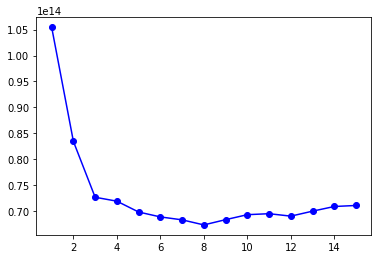

In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

### QUIZ QUESTION

In [139]:
# What is the RSS on the TEST data using the value of k found above?
# To be clear, sum over all houses in the TEST set.

In [143]:
pred = multiple_predictkNN(8, features_train, output_train, features_test)
    
print "%e" % RSS(output_test, pred)

1.330917e+14
